In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cluster import DBSCAN
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

IMPORT / TRAIN-TEST SPLIT

In [3]:
#original
data = pd.read_csv('DSCapstoneKaggleTrain.csv')
target = data['class']
features = data.drop('class', axis=1)
features = features.set_index('id')
X = preprocessing.StandardScaler().fit_transform(X=features)
y = target.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
data = pd.read_csv('DSCapstoneKaggleTrain.csv')
target = data['class']
features = data.drop(['class','Unnamed: 0'], axis=1)
features = features.set_index('id')
X = preprocessing.StandardScaler().fit_transform(X=features)
y = target.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
X_train[0][0]

0.4715497932761799

EDA

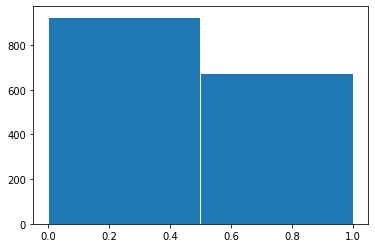

In [66]:
# print(data.head(5))
fig, ax = plt.subplots()
ax.hist(y_test, bins=2, edgecolor="white")
# A bit more 0's than 1's in the response, so stratify to be safe
plt.show()

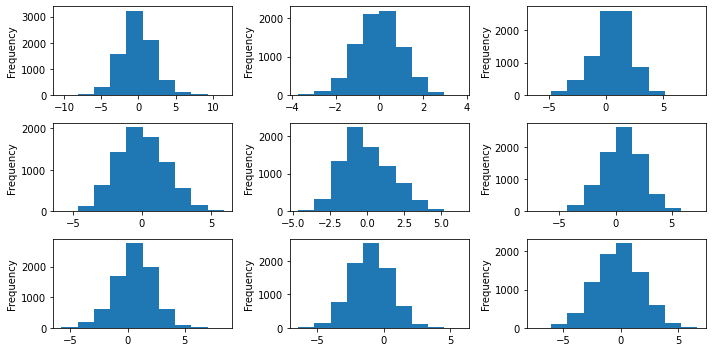

In [79]:
# All features pretty normal
figure, axes = plt.subplots(nrows=3, ncols=3, figsize =(10,5))
row = 0
col = 0

for i in range(1, 10):
    data[str(i)].plot(ax=axes[row, col], kind='hist', xlabel=str(i), rot=0, ylabel='')
    col = col+1 if col < 2 else 0
    row = row + 1 if col == 0 else row
plt.tight_layout()
plt.show()

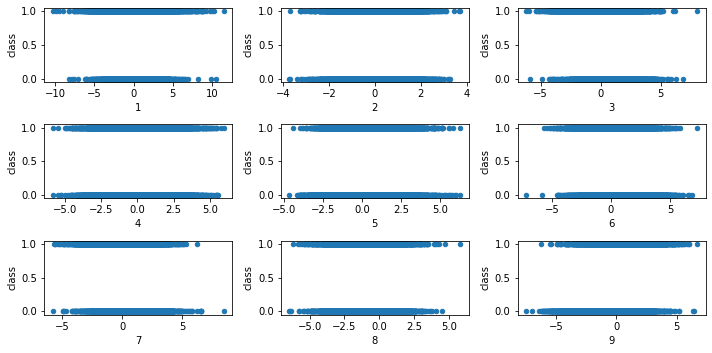

In [80]:
# No feature range favors one class or the other
#   EX: Maybe higher values for feature 2 tend to be class 1, and lower features tend to be class 0
#   This doesn't seem to be the case - MAYBE feature 9 slightly...
figure, axes = plt.subplots(nrows=3, ncols=3, figsize =(10,5))
row = 0
col = 0

for i in range(1, 10):
    data.plot(x = str(i), y = 'class', ax=axes[row, col], kind='scatter', xlabel=str(i), rot=0, ylabel='class')
    col = col+1 if col < 2 else 0
    row = row + 1 if col == 0 else row
plt.tight_layout()
plt.show()

UNSUPERVISED EDA

In [81]:
unsupervised = DBSCAN(eps=.8, metric='cityblock', min_samples=25)
clusters = unsupervised.fit(np.array(target).reshape(-1, 1))

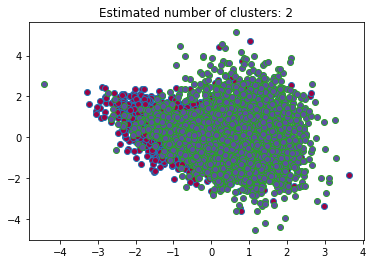

In [82]:
core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

labels = clusters.labels_

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="r",
        markersize=6,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="y",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

MLP

In [6]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(100,), random_state=1, max_iter=20000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("MLP ACCURACY: ", accuracy_score(y_test, y_pred))

MLP ACCURACY:  0.824375


XGBoost attempt

In [7]:
#Just using default parameters for now
model = xgb.XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
y_pred_xg = model.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

In [10]:
accuracy = accuracy_score(y_test, predictions_xg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.69%


In [26]:
# Testing on the model
dataTest = pd.read_csv('DSCapstoneKaggleTest.csv')
features = dataTest.drop(['Unnamed: 0'], axis=1)

features.set_index("id", inplace=True)
stand = preprocessing.StandardScaler().fit_transform(X=features)
predictionsTest = model.predict(stand)
pd.DataFrame(predictionsTest).to_csv('Results1HaloSight1.csv')
len(predictionsTest)



2000